# Other Census Bureau datasets

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mmann1123/pytidycensus/blob/main/examples/04_other_datasets.ipynb)

## Population Estimates Program (PEP)

  - Purpose: Provides annual population estimates between decennial censuses
  - Frequency: Updated annually
  - Geographic Coverage: US, regions, divisions, states, counties, metro areas, places
  - Time Range: 2010-present (function supports 2015+)


### Specific Datasets Within PEP

  1. Population Totals (product=`"population"`)
    - Basic population counts by geography
    - Annual estimates for intercensal years
  2. Components of Change (product=`"components"`)
    - Births, deaths, migration flows
    - Natural change calculations
    - Domestic and international migration
  3. Population Characteristics (product=`"characteristics"`)
    - Demographics by Age, Sex, Race, Hispanic Origin (ASRH)
    - Population breakdowns by key demographic categories


### Key Parameters
- **`product`**: "population", "components", "characteristics"
- **`variables`**: "POP", "BIRTHS", "DEATHS", migration variables, rates
- **`breakdown`**: ["SEX", "RACE", "ORIGIN", "AGEGROUP"] for demographics
- **`vintage`**: Dataset version (e.g., 2024 for most recent)
- **`year`**: Specific data year (defaults to vintage)
- **`time_series`**: Get multi-year data
- **`geometry`**: Add geographic boundaries
- **`output`**: "tidy" (default) or "wide" format

### Data Sources  
- **2020+**: CSV files from Census Bureau FTP servers
- **2015-2019**: Census API (requires API key)
- **Automatic handling**: No user intervention needed

### Geographic Support
All major Census geographies: US, regions, divisions, states, counties, CBSAs, CSAs, places

## Mapping Migration Estimates

Let's create a map of net migration rates:

### Census API Key

To use pytidycensus, you need a free API key from the US Census Bureau. Get one at: https://api.census.gov/data/key_signup.html


In [1]:
import pytidycensus as tc
import pandas as pd
import matplotlib.pyplot as plt

tc.set_census_api_key("YOUR API KEY GOES HERE")


Census API key has been set for this session.


Ignore the next cell. It is just to show how users can load their credentials using the new utility function. 

In [2]:
# Do not run this cell. It is just to show how users can load their credentials using the new utility function.
import pytidycensus as tc

credentials = tc.get_credentials().get("census_api_key")
tc.set_census_api_key(credentials)

Census API key has been set for this session.


## Product Types and Variables

The `get_estimates()` function supports three main products:

1. **population** (default) - Basic population totals
2. **components** - Components of population change 
3. **characteristics** - Population by demographics

### Available Variables

Common variables include:
- **POP**: Total population
- **BIRTHS**: Births 
- **DEATHS**: Deaths
- **DOMESTICMIG**: Domestic migration
- **INTERNATIONALMIG**: International migration
- **NETMIG**: Net migration
- **NATURALCHG**: Natural change (births - deaths)
- **RNETMIG**: Net migration rate

In [3]:

# Get county data with geometry for mapping
counties_geo = tc.get_estimates(
    geography="county",
    variables="RNETMIG",  # Net migration rate
    year=2022,
    geometry=True,
    state=["CA", "NV", "AZ"],  # Western states
)

print("County data with geometry:", counties_geo.shape)
print("Data types:", type(counties_geo))
counties_geo.head(3)

Getting data from the 2024 Population Estimates Program (vintage 2024)


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Loading county boundaries...
County data with geometry: (90, 7)
Data types: <class 'geopandas.geodataframe.GeoDataFrame'>


,GEOID,geometry,STATEFP,COUNTYFP,NAMELSAD,NAME,RNETMIG2022
0,06091,"POLYGON ((-120.55587 39.50874, -120.55614 39.5...",06,091,Sierra County,"Sierra County, California",-19.960080
1,32001,"POLYGON ((-119.22613 39.90038, -119.2261 39.90...",32,001,Churchill County,"Churchill County, Nevada",9.048192
2,32013,"POLYGON ((-119.33142 41.0391, -119.3314 41.041...",32,013,Humboldt County,"Humboldt County, Nevada",-20.804677


## Mapping with Geometry

Because we set `geometry=True`, the returned GeoDataFrame includes geometry data for mapping.

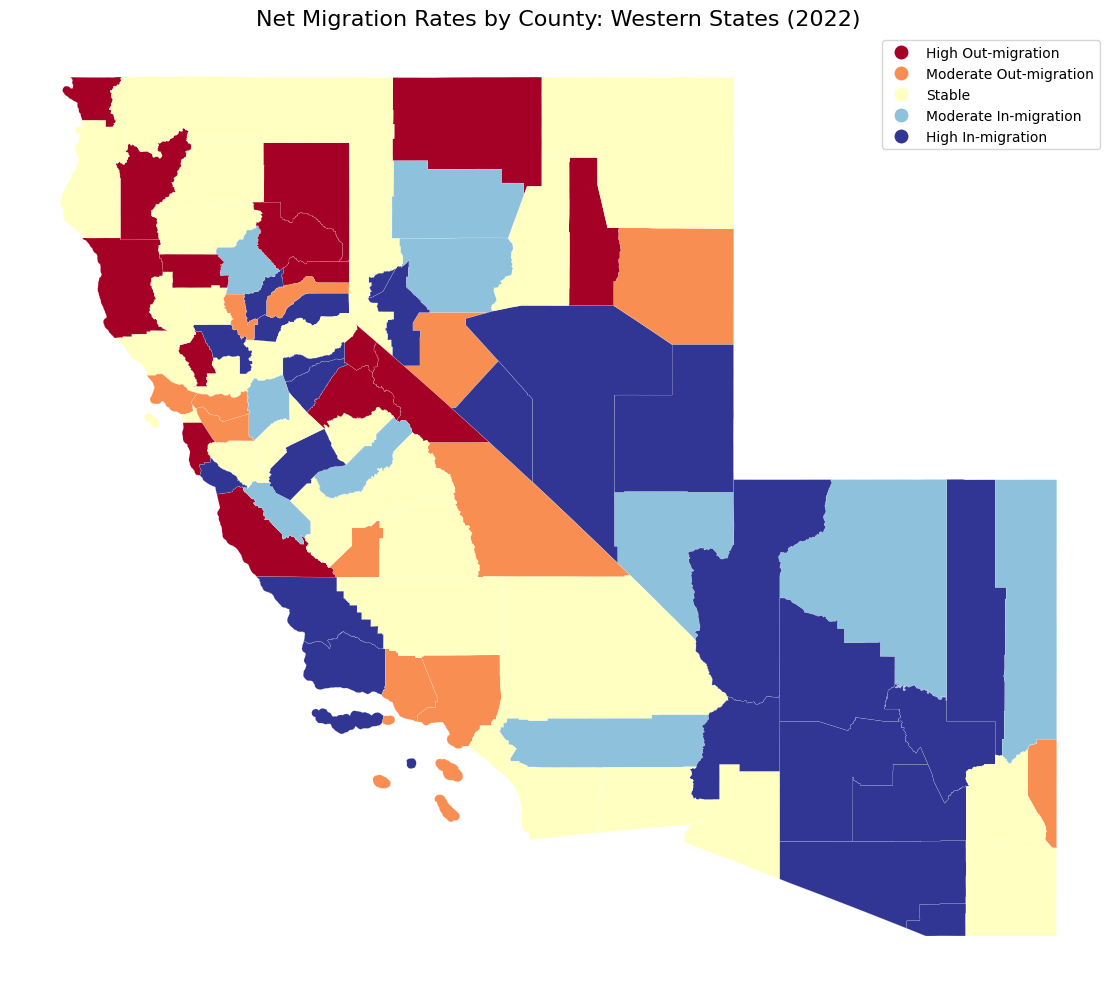

In [12]:
# Create a map of net migration rates
fig, ax = plt.subplots(figsize=(15, 10))

# Create migration categories for better visualization
counties_geo["migration_category"] = pd.cut(
    counties_geo["RNETMIG2022"],
    bins=[-float("inf"), -10, -5, 5, 10, float("inf")],
    labels=[
        "High Out-migration",
        "Moderate Out-migration",
        "Stable",
        "Moderate In-migration",
        "High In-migration",
    ],
)

# Plot the map
counties_geo.plot(
    column="migration_category",
    legend=True,
    ax=ax,
    cmap="RdYlBu",
    edgecolor="white",
    linewidth=0.1,
)

ax.set_title("Net Migration Rates by County: Western States (2022)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

## Geographic Levels

Population estimates support multiple geographic levels beyond states:

In [5]:
# Metropolitan areas (CBSAs) 
metros = tc.get_estimates(
    geography="cbsa",
    variables="POP", 
    year=2022
)

print(f"Metro areas: {metros.shape[0]} CBSAs")
print("Largest metropolitan areas:")
metros_largest = metros.nlargest(10, 'POPESTIMATE2022')
print(metros_largest[['NAME', 'POPESTIMATE2022']])

/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Getting data from the 2024 Population Estimates Program (vintage 2024)
Metro areas: 925 CBSAs
Largest metropolitan areas:
                                              NAME  POPESTIMATE2022
1030            New York-Newark-Jersey City, NY-NJ         19619844
860             Los Angeles-Long Beach-Anaheim, CA         12906936
293                Chicago-Naperville-Elgin, IL-IN          9310017
394                Dallas-Fort Worth-Arlington, TX          7973603
640             Houston-Pasadena-The Woodlands, TX          7403068
1521  Washington-Arlington-Alexandria, DC-VA-MD-WV          6289810
65               Atlanta-Sandy Springs-Roswell, GA          6253070
1126   Philadelphia-Camden-Wilmington, PA-NJ-DE-MD          6252024
929      Miami-Fort Lauderdale-West Palm Beach, FL          6211194
1142                     Phoenix-Mesa-Chandler, AZ          5029933


In [6]:
# County-level data for Texas
tx_counties = tc.get_estimates(
    geography="county",
    variables="POP",
    state="TX",
    year=2022
)

print(f"Texas counties: {tx_counties.shape[0]} counties")
print("Largest Texas counties by population:")
tx_largest = tx_counties.nlargest(10, 'POPESTIMATE2022')
print(tx_largest[['NAME', 'POPESTIMATE2022']])

Getting data from the 2024 Population Estimates Program (vintage 2024)


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Texas counties: 254 counties
Largest Texas counties by population:
                         NAME  POPESTIMATE2022
2669     Harris County, Texas          4806747
2625     Dallas County, Texas          2613712
2788    Tarrant County, Texas          2161670
2583      Bexar County, Texas          2063840
2795     Travis County, Texas          1332544
2611     Collin County, Texas          1163724
2629     Denton County, Texas           980355
2647  Fort Bend County, Texas           893319
2676    Hidalgo County, Texas           889799
2639    El Paso County, Texas           868890


In [7]:
# Get time series data for select states
time_series_states = tc.get_estimates(
    geography="state",
    variables="POP",
    time_series=True,
    vintage=2023,  # Use 2023 vintage for data through 2023
    state=["CA", "TX", "FL", "NY"],  # Focus on large states
)

print("Time series data shape:", time_series_states.shape)
print("Years available:", sorted(time_series_states["year"].unique()))
time_series_states.head(10)

Getting data from the 2023 Population Estimates Program (vintage 2023)
Time series data shape: (16, 5)
Years available: [2020, 2021, 2022, 2023]


,GEOID,NAME,variable,year,estimate
0,06,California,POPESTIMATE,2020,39503200
1,12,Florida,POPESTIMATE,2020,21591299
2,36,New York,POPESTIMATE,2020,20104710
3,48,Texas,POPESTIMATE,2020,29234361
4,06,California,POPESTIMATE,2021,39145060
5,12,Florida,POPESTIMATE,2021,21830708
6,36,New York,POPESTIMATE,2021,19854526
7,48,Texas,POPESTIMATE,2021,29561286
8,06,California,POPESTIMATE,2022,39040616
9,12,Florida,POPESTIMATE,2022,22245521


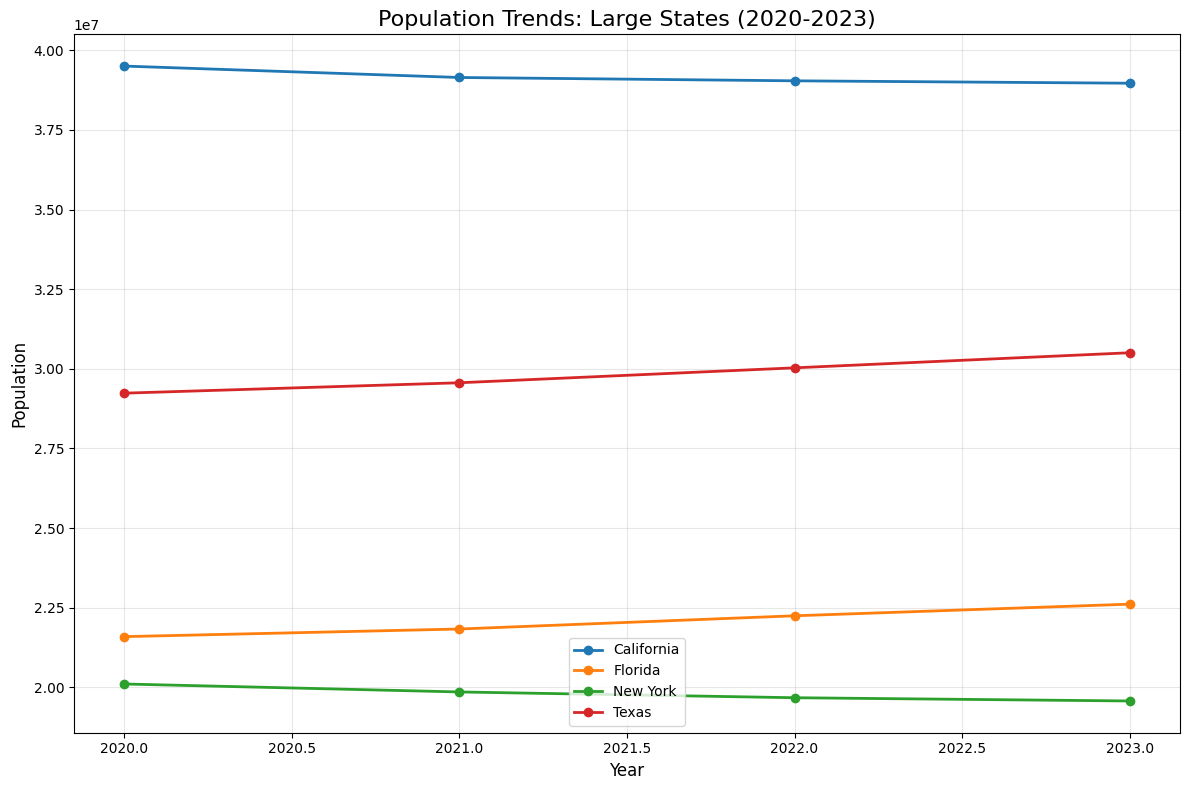

In [8]:
# Plot population trends
plt.figure(figsize=(12, 8))

for state in time_series_states['NAME'].unique():
    state_data = time_series_states[time_series_states['NAME'] == state]
    plt.plot(state_data['year'], state_data['estimate'], 
             marker='o', linewidth=2, label=state)

plt.title('Population Trends: Large States (2020-2023)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Basic Population Estimates

Let's start with basic population estimates by state:

In [9]:
# Get population estimates for US states
us_pop_estimates = tc.get_estimates(
    geography="state",
    variables="POP",
    year=2022
)

print(f"Shape: {us_pop_estimates.shape}")
print("Data format:", us_pop_estimates.columns.tolist())
us_pop_estimates.head()

Getting data from the 2024 Population Estimates Program (vintage 2024)
Shape: (52, 3)
Data format: ['GEOID', 'NAME', 'POPESTIMATE2022']


/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


,GEOID,NAME,POPESTIMATE2022
14,01,Alabama,5076181
15,02,Alaska,734442
16,04,Arizona,7377566
17,05,Arkansas,3047704
18,06,California,39142414


In [10]:
# Get components of population change
us_components = tc.get_estimates(
    geography="state",
    product="components",  # Specify components product
    variables=["BIRTHS", "DEATHS", "DOMESTICMIG", "INTERNATIONALMIG"],
    year=2022,
    output="tidy"  # Tidy format for easier analysis
)

print("Components data shape:", us_components.shape)
print("Variables available:", us_components['variable'].unique())
us_components.head(10)

/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Getting data from the 2024 Population Estimates Program (vintage 2024)
Components data shape: (208, 4)
Variables available: ['BIRTHS2022' 'DEATHS2022' 'DOMESTICMIG2022' 'INTERNATIONALMIG2022']


,GEOID,NAME,variable,estimate
0,01,Alabama,BIRTHS2022,58103
1,02,Alaska,BIRTHS2022,9359
2,04,Arizona,BIRTHS2022,79173
3,05,Arkansas,BIRTHS2022,36115
4,06,California,BIRTHS2022,424071
5,08,Colorado,BIRTHS2022,62659
6,09,Connecticut,BIRTHS2022,35637
7,10,Delaware,BIRTHS2022,10849
8,11,District of Columbia,BIRTHS2022,8502
9,12,Florida,BIRTHS2022,221941


## Demographic Breakdowns

One of the most powerful features is demographic breakdowns using the `breakdown` parameter. This accesses the Age, Sex, Race, Hispanic Origin (ASRH) datasets:

In [11]:
# Get population by sex for all states
pop_by_sex = tc.get_estimates(
    geography="state",
    variables="POP",
    breakdown=["SEX"],
    breakdown_labels=True,  # Include human-readable labels
    year=2022
)

print("Population by sex data:")
print(pop_by_sex.head(10))

# Check the breakdown categories
if 'SEX_label' in pop_by_sex.columns:
    print("\nSex categories:", pop_by_sex['SEX_label'].unique())

/home/mmann1123/Documents/github/pytidycensus/pytidycensus/estimates.py:757: UserWarning: Using vintage 2024 data for year 2022. Consider setting vintage=2022 if available.
  warnings.warn(


Getting data from the 2024 Population Estimates Program (vintage 2024)
Processing characteristics data with breakdown: ['SEX']
Population by sex data:
   STATE        NAME  SEX  ORIGIN  RACE  AGE GEOID  estimate  year variable  \
0      1     Alabama    1       0     0    0    01     29531  2022      POP   
1      1     Alabama    2       0     0    0    01     28195  2022      POP   
2      2      Alaska    1       0     0    0    02      4808  2022      POP   
3      2      Alaska    2       0     0    0    02      4504  2022      POP   
4      4     Arizona    1       0     0    0    04     40228  2022      POP   
5      4     Arizona    2       0     0    0    04     38496  2022      POP   
6      5    Arkansas    1       0     0    0    05     18258  2022      POP   
7      5    Arkansas    2       0     0    0    05     17590  2022      POP   
8      6  California    1       0     0    0    06    217463  2022      POP   
9      6  California    2       0     0    0    06    20833